# 1.  Quora Question Pair Similarity 

## 1.1Problem Statement :
Identifying Given pair of questions are Duplicates or not (Similar or not) to provide instant answers 

##### Business objectives and Constraints:
    * cost of miss-classification is very high as customer might get disaapointed with the provided answers
    * No-strict latency requirements (can take some time to provide the answers)
    * Probability of questions being similar to put a threshold
    * Interpretability is partially important

### 1.2 Mapping Real world problem to machine-leanring Problem:
* It's  binary Classification problem (whether the given pair of questions are duplicates are not)


#### Performance Metric to Evaluate the Model:
    * log-loss (As we need probabilities of each prediction) as Primary KPI
    * Confusion-matrix as secondary KPI

#### Overvoew of Dataset:
<p> 
- Data will be in a file train.csv <br>
- Train.csv contains 5 columns : qid1, qid2, question1, question2, is_duplicate <br>
- Size of Train.csv - 60MB <br>
- Number of rows in Train.csv = 404,290
</p>

##### Description of columns:
    * qid1 : unique ID of question number 1
    * qid2 : unique ID of question number 2
    * question1 : Textual content of question1
    * question2 : Textual content of question2
    * is_diplicate : target variable ( whether the given pair of question are duplicates or not) 
        **Note** : 0 : Given pair of questions are not duplicate
                   1 : Given pair of questions are duplicate

##### Train-Test Construction of Dataset:
We build train and test by randomly splitting in the ratio of 70:30  



## 2. Exploratory Data-Analysis :

In [8]:
#importing required libraries
%matplotlib inline
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#Importing required libraries
from fuzzywuzzy import fuzz
import distance
from wordcloud import WordCloud, STOPWORDS
from os import path
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import TfidfVectorizer
warnings.filterwarnings("ignore")
import sys
from tqdm import tqdm
import spacy
import re
import nltk
from spacy import en_core_web_sm
from nltk.corpus import stopwords
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
import time
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import datetime as dt
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from collections import Counter
from scipy.sparse import hstack
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import  RandomizedSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import log_loss
from xgboost import plot_importance
from matplotlib import pyplot
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.calibration import CalibratedClassifierCV
from prettytable import PrettyTable

#importing data into pandas datframe
quora_data = pd.read_csv("train.csv")

In [2]:
#checking for number data-points in given dataset
print("Number of data-points in given dataset :" , quora_data.shape[0])

Number of data-points in given dataset : 404290


In [3]:
#getting the column names and number of column attributes
print( "Number of column attributes : " ,quora_data.shape[1])

print(list(quora_data.columns))

Number of column attributes :  6
['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate']


In [4]:
#getting the information of each column and checking for null-values
quora_data.info()
quora_data.isnull().any()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


id              False
qid1            False
qid2            False
question1        True
question2        True
is_duplicate    False
dtype: bool

##### Observations :
    * We can see columns like question1 and question2 contains null-values

In [5]:
#Checking whether there are any rows with null values
print (quora_data[quora_data.isnull().any(1)])

# Filling the null values with ' '
quora_data = quora_data.fillna('')
nan_rows = quora_data[quora_data.isnull().any(1)]
print (nan_rows)

            id    qid1    qid2                         question1  \
105780  105780  174363  174364    How can I develop android app?   
201841  201841  303951  174364  How can I create an Android app?   
363362  363362  493340  493341                               NaN   

                                                question2  is_duplicate  
105780                                                NaN             0  
201841                                                NaN             0  
363362  My Chinese name is Haichao Yu. What English na...             0  
Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


In [6]:
#getting the head of the dataset for a better understainding of the data-set
quora_data.head(5)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


### 2.1 Distribution of class-label (is_duplicate) :

0    255027
1    149263
Name: is_duplicate, dtype: int64


Text(0.5,0,'class labels')

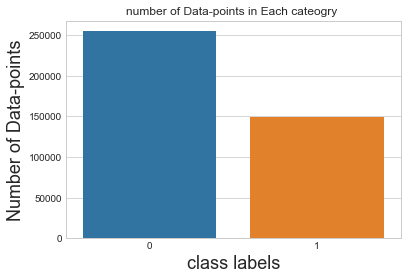

In [7]:
#checking whether the given dataset is balanced or not
duplicate_counts = quora_data["is_duplicate"].value_counts()
print(duplicate_counts)

#ploting for distribution of class-labels
sns.set_style('whitegrid')
sns.barplot(duplicate_counts.index , duplicate_counts.values)
plt.title("number of Data-points in Each cateogry ")
plt.ylabel('Number of Data-points', fontsize=18)
plt.xlabel('class labels', fontsize=18) 


In [8]:
#getting the percentage distribtuion of each category
similar_pairs = round(quora_data["is_duplicate"].mean()*100,2)
not_similar_pairs = 100 - similar_pairs

print("Percantage of give question pairs which are simliar(is_dulicate ==1) is:{}%".format(similar_pairs))
print("Percantage of give question pairs which are  not simliar(is_duplicate ==0) is:{}%".format(not_similar_pairs))

Percantage of give question pairs which are simliar(is_dulicate ==1) is:36.92%
Percantage of give question pairs which are  not simliar(is_duplicate ==0) is:63.08%


#### Observations :
    * Given Dataset is a imbalanced one with majority of given question pairs not being similar

In [9]:
#checking for number of unique queations present in the data
ids = pd.Series(quora_data["qid1"].tolist()+quora_data["qid2"].tolist())
unique_ids = len(np.unique(ids))
repeated_ids = np.sum(ids.value_counts() > 1)

print("Number of unique questions : {}".format(unique_ids))
print("Number of Repeated questions : {}".format(repeated_ids))

Number of unique questions : 537933
Number of Repeated questions : 111780


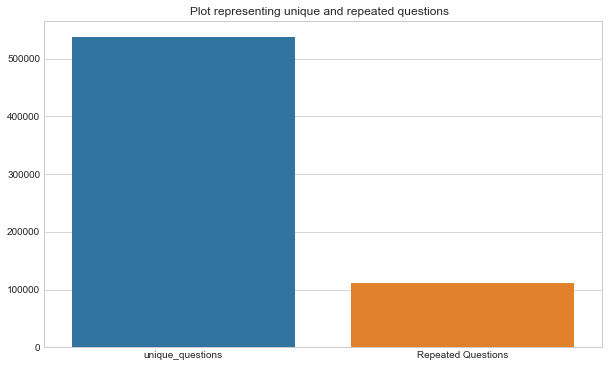

In [10]:
#ploting for unique and repeated questions count
x = ["unique_questions" , "Repeated Questions"]
y =  [unique_ids , repeated_ids]

plt.figure(figsize=(10, 6))
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x,y)
plt.show()

In [11]:
#chekcing for Duplicates (whether a given pair of questions are repeated or not)
pair_duplicates = quora_data[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()

print ("Number of duplicate questions",(pair_duplicates).shape[0] - quora_data.shape[0])

Number of duplicate questions 0


Maximum number of times a single question is repeated: 157



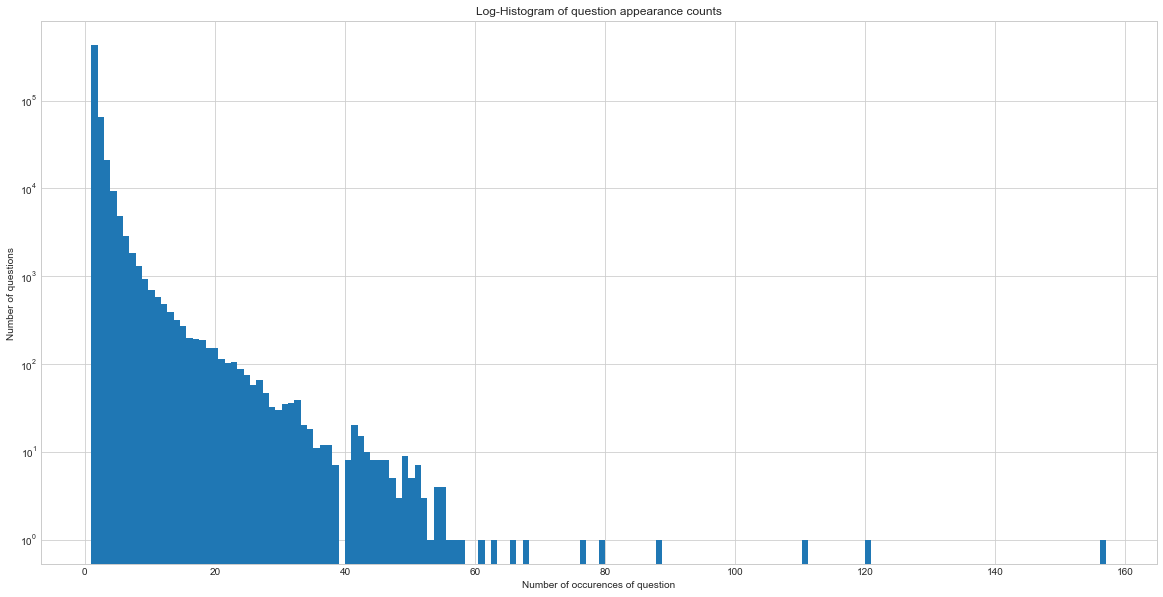

In [12]:
#checking for occurence of each question
plt.figure(figsize=(20, 10))

plt.hist(ids.value_counts(), bins=160)

plt.yscale('log', nonposy='clip')

plt.title('Log-Histogram of question appearance counts')

plt.xlabel('Number of occurences of question')

plt.ylabel('Number of questions')

print ('Maximum number of times a single question is repeated: {}\n'.format(max(ids.value_counts()))) 

#### Observations:
    * Most number of questions occur less than 10 times
    * few questions are repeated for more than 100 times ,with one question repeating for 157 times at maximum

## 3. Feature-Extraction:

Let us now construct a few features like:
 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's 
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 

In [ ]:
#getting the frequency of ids of each queation in a data-point
quora_data['freq_qid1'] = quora_data.groupby('qid1')['qid1'].transform('count') 
quora_data['freq_qid2'] = quora_data.groupby('qid2')['qid2'].transform('count')

    
#getting the length of each question in data-point    
quora_data['q1len'] = quora_data['question1'].str.len() 
quora_data['q2len'] = quora_data['question2'].str.len()

#getting the number of words in each question
quora_data['q1_n_words'] = quora_data['question1'].apply(lambda row: len(row.split(" ")))
quora_data['q2_n_words'] = quora_data['question2'].apply(lambda row: len(row.split(" ")))

#number of unique common words in question1 and question2
def normalized_word_Common(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * len(w1 & w2)
quora_data['word_Common'] = quora_data.apply(normalized_word_Common, axis=1)

    
#total number of words in both the questions    
def normalized_word_Total(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * (len(w1) + len(w2))
quora_data['word_Total'] = quora_data.apply(normalized_word_Total, axis=1)

#getting the word share between both questions    
def normalized_word_share(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
quora_data['word_share'] = quora_data.apply(normalized_word_share, axis=1)

#getting the total frequency of ids of both questions
quora_data['freq_q1+q2'] = quora_data['freq_qid1']+quora_data['freq_qid2']
#getting the difference in frequency of ids of both the questions
quora_data['freq_q1-q2'] = abs(quora_data['freq_qid1']-quora_data['freq_qid2'])

In [5]:
#saving the file to csv
if os.path.isfile('quora_data_new.csv'):
    df = pd.read_csv("quora_data_new.csv")
else:
    quora_data.to_csv("quora_data_new.csv", index=False)


In [15]:
#getting the head of the new extracted data
df.head(5)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


### 3.1 Analysis of Extracted Features:

In [16]:
print ("Minimum length of the questions in question1 : " , min(df['q1_n_words']))

print ("Minimum length of the questions in question2 : " , min(df['q2_n_words']))

print ("Number of Questions with minimum length [question1] :", df[df['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", df[df['q2_n_words']== 1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 67
Number of Questions with minimum length [question2] : 24


### Observations :
    * There are questions with only one word

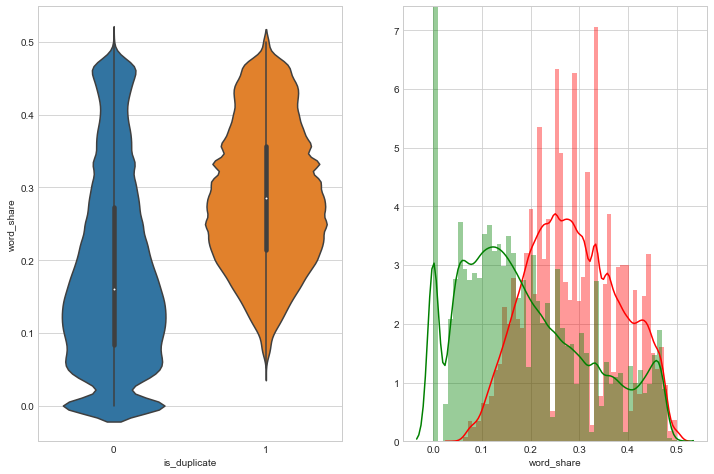

In [17]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color = 'green' )
plt.show()

#### Observations:
    * As the word share increased ,the chance of questions being similar is also increased,which we can see from the red 
    color distribution plot in second graph
    * As there is significant overlap between the distrobution plots of both the class labels, 
    we cannot get a threshold for the classification
    *we can see a considerable amount of overlap between the distibution of word share feature among class labels.
    less the overlap,better is the feautre for classification
    * average word share is more when the queations are duplicate
    

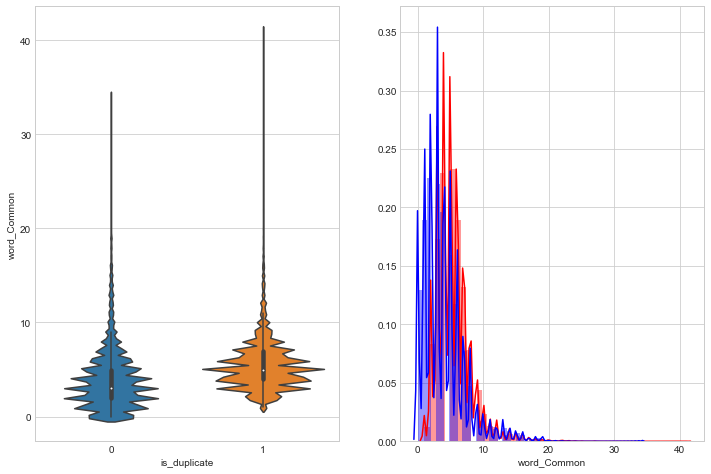

In [19]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Common', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_Common'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_Common'][0:] , label = "0" , color = 'blue' )
plt.show()

### Observations:
    * the distributions are highly overlapping, we cannot infer anything from the graph

## 4. Text-Preprocessing

In [20]:
STOP_WORDS = stopwords.words('english')

#pre-defined finctions to remove html tags ,punctuations, special characters

#function fro removing html tags
def remove_html (sentence):
    cleanhtml = re.compile('<.*?>')
    clean_text = re.sub(cleanhtml,' ',str(sentence))
    return clean_text

#function for removing punctuations and special characters
def remove_punc(sentence):
    cleanpunc = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleanpunc = re.sub(r'[.|,|)|(|\|/]',r' ',cleanpunc)
    cleanpunc = cleanpunc.strip()
    cleanpunc = cleanpunc.replace("\n" ,'')
    return cleanpunc

#applying all pre-processing functions on the text to get cleaned text for question1
df['question1'] = df['question1'].str.lower()
df['question1'] =df['question1'].apply(remove_html)
df['question1']= df['question1'].apply(remove_punc)
#applying all pre-processing functions on the text to get cleaned text for queation2
df['question2'] = df['question2'].str.lower()
df['question2'] =df['question2'].apply(remove_html)
df['question2']= df['question2'].apply(remove_punc)

In [21]:
# To get the results in 4 decemal points
SAFE_DIV = 0.0001 

#removing contractions
def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x

## 5.  Advanced Feature Extraction

Definition:
- __Token__: You get a token by splitting sentence a space
- __Stop_Word__ : stop words as per NLTK.
- __Word__ : A token that is not a stop_word


Features:
- __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
<br>
<br>
- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
<br>
<br>
- __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
<br>
<br>
- __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
<br>
<br>
- __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
<br>
<br>

- __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
<br>
<br>
        
- __last_word_eq__ :  Check if First word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
<br>
<br>

- __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
<br>
<br>
        
- __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
<br>
<br>

- __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
<br>
<br>


- __fuzz_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>

- __fuzz_partial_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_sort_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_set_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>





- __longest_substr_ratio__ :  Ratio of length longest common substring to min lenghth of token count of Q1 and Q2<br>longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))


In [ ]:
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
    # preprocessing each question
    quora_data["question1"] = quora_data["question1"].fillna("").apply(preprocess)
    quora_data["question2"] = quora_data["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    token_features = quora_data.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    quora_data["cwc_min"]       = list(map(lambda x: x[0], token_features))
    quora_data["cwc_max"]       = list(map(lambda x: x[1], token_features))
    quora_data["csc_min"]       = list(map(lambda x: x[2], token_features))
    quora_data["csc_max"]       = list(map(lambda x: x[3], token_features))
    quora_data["ctc_min"]       = list(map(lambda x: x[4], token_features))
    quora_data["ctc_max"]       = list(map(lambda x: x[5], token_features))
    quora_data["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    quora_data["first_word_eq"] = list(map(lambda x: x[7], token_features))
    quora_data["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    quora_data["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset
    print("fuzzy features..")

    quora_data["token_set_ratio"]       = quora_data.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    quora_data["token_sort_ratio"]      = quora_data.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    quora_data["fuzz_ratio"]            = quora_data.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    quora_data["fuzz_partial_ratio"]    = quora_data.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    quora_data["longest_substr_ratio"]  = quora_data.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return quora_data

In [ ]:
quora_data_preprocess = extract_features(quora_data)

In [22]:
#saving the file to csv
if os.path.isfile('quora_preprocess.csv'):
    df1 = pd.read_csv("quora_preprocess.csv")

In [23]:
df_duplicate =df1[df1['is_duplicate'] == 1]
df_nonduplicate =df1[df1['is_duplicate'] == 0]

# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
p = np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
n = np.dstack([df_nonduplicate["question1"], df_nonduplicate["question2"]]).flatten()

print ("Number of data points in class 1 (duplicate pairs) :",len(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(n))


Number of data points in class 1 (duplicate pairs) : 298526
Number of data points in class 0 (non duplicate pairs) : 510054


In [24]:
# reading the text files and removing the Stop Words:

d = path.dirname('.')

textp_w = open(path.join(d, 'train_p.txt')).read()
textn_w = open(path.join(d, 'train_n.txt')).read()
stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")

stopwords.remove("no")
#stopwords.remove("good")
#stopwords.remove("love")
stopwords.remove("like")
#stopwords.remove("best")
#stopwords.remove("!")
print ("Total number of words in duplicate pair questions :",len(textp_w))
print ("Total number of words in non duplicate pair questions :",len(textn_w))

Total number of words in duplicate pair questions : 16109886
Total number of words in non duplicate pair questions : 33193130


Word Cloud for Duplicate Question pairs


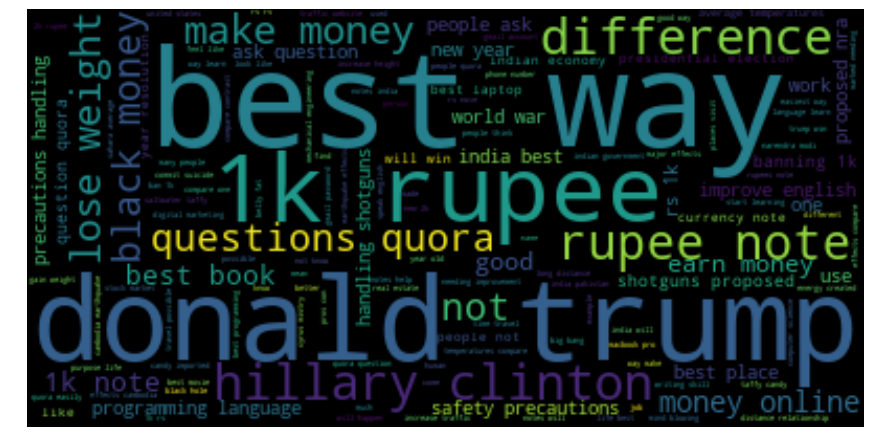

In [25]:
#word cloud for words in duplicate question pairs
plt.figure(figsize=(15,10))
wc = WordCloud(background_color="black", max_words=len(textp_w), stopwords=stopwords)
wc.generate(textp_w)
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

Word Cloud for non-Duplicate Question pairs:


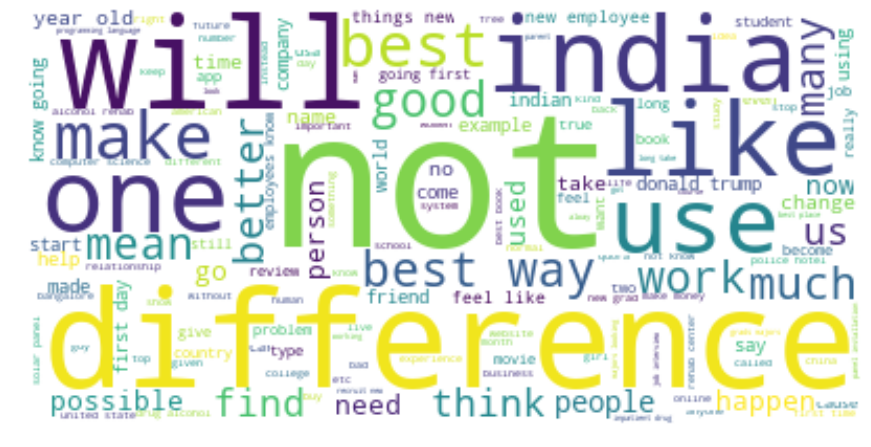

In [26]:
#word cloud for question in non-duplicate pairs
plt.figure(figsize=(15,10))
wc = WordCloud(background_color="white", max_words=len(textn_w),stopwords=stopwords)
wc.generate(textn_w)
print ("Word Cloud for non-Duplicate Question pairs:")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

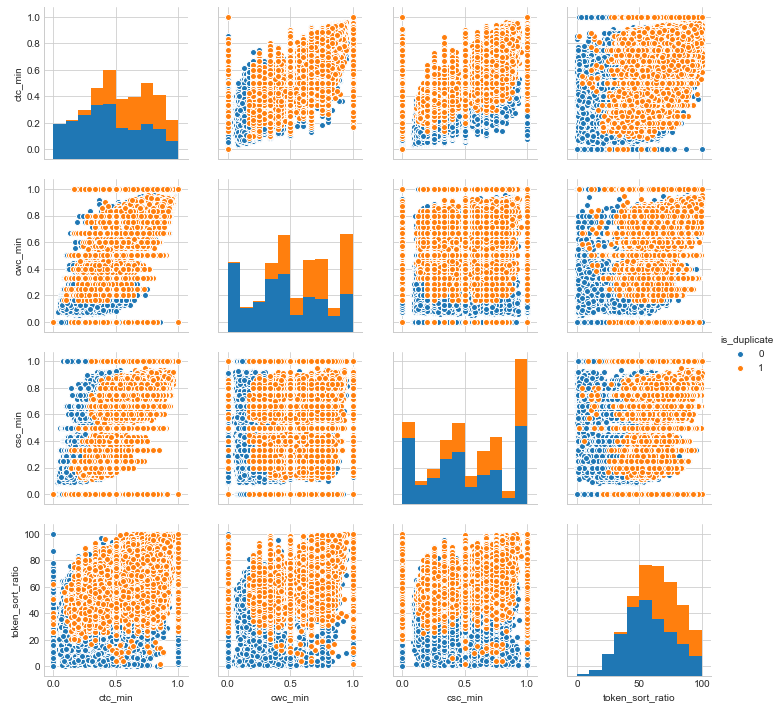

In [27]:
n = df1.shape[0]
sns.pairplot(df1[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

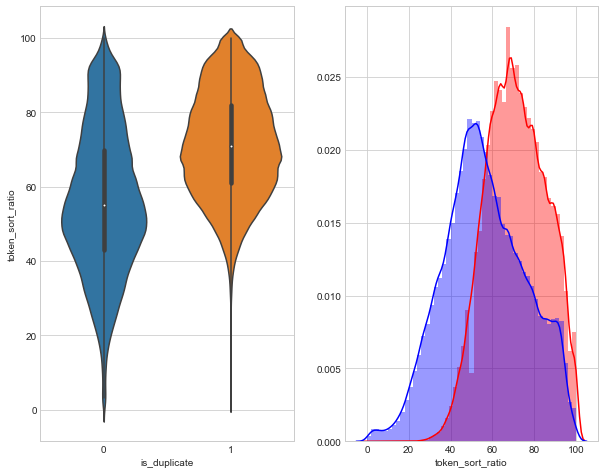

In [28]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data =df1[0:] , )

plt.subplot(1,2,2)
sns.distplot(df1[df1['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df1[df1['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

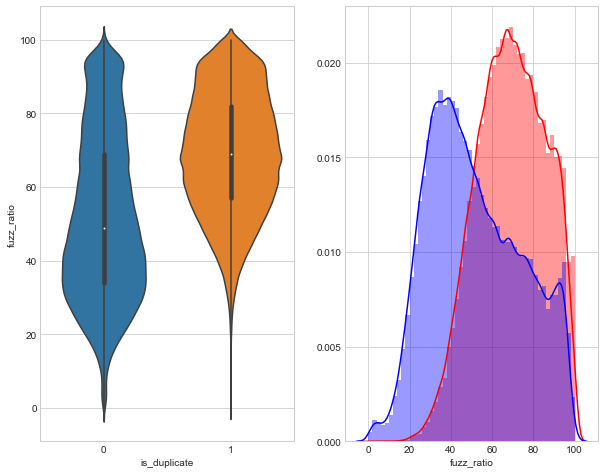

In [29]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = df1[0:] , )

plt.subplot(1,2,2)
sns.distplot(df1[df1['is_duplicate'] == 1.0]['fuzz_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df1[df1['is_duplicate'] == 0.0]['fuzz_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

## 5.1 T-SNE Visualization

In [30]:
df1_subsampled = df1[0:10000]
X = MinMaxScaler().fit_transform(df1_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = df1_subsampled['is_duplicate'].values
tsne2d = TSNE(n_components=2,init='random', random_state=101,method='barnes_hut',
              n_iter=1000, verbose=2, angle=0.5).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.027s...
[t-SNE] Computed neighbors for 10000 samples in 0.822s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.106137
[t-SNE] Computed conditional probabilities in 0.337s
[t-SNE] Iteration 50: error = 96.5224533, gradient norm = 0.0166664 (50 iterations in 11.924s)
[t-SNE] I

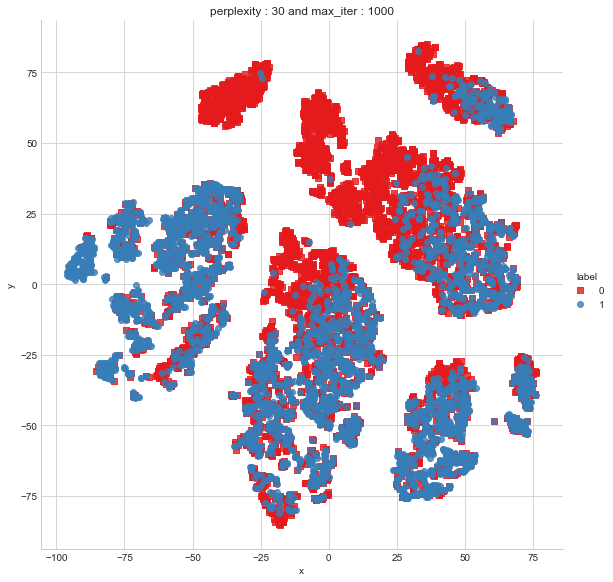

In [31]:
df2 = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})
# draw the plot in appropriate place in the grid
sns.lmplot(data=df2, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

<h2> 6. Featurizing text data with tfidf weighted word-vectors </h2>

In [2]:
# avoid decoding problems
df = pd.read_csv("train.csv")

df['question1'] = df['question1'].apply(lambda x: str(x))
df['question2'] = df['question2'].apply(lambda x: str(x))

In [3]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
# merge texts
questions = list(df['question1']) + list(df['question2'])

tfidf = TfidfVectorizer(lowercase=False, )
tfidf.fit_transform(questions)

# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

- After we find TF-IDF scores, we convert each question to a weighted average of word2vec vectors by these scores.
- here we use a pre-trained GLOVE model which comes free with "Spacy".  https://spacy.io/usage/vectors-similarity
- It is trained on Wikipedia and therefore, it is stronger in terms of word semantics. 

In [5]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
nlp = spacy.load('en_core_web_sm')

vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(df['question1'])):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), 384])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
df['q1_feats_m'] = list(vecs1)


100%|████████████████████████████████████████████████████████████████████████| 404290/404290 [2:13:51<00:00, 50.34it/s]


In [6]:
vecs2 = []
for qu2 in tqdm(list(df['question2'])):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc2), 384])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
df['q2_feats_m'] = list(vecs2)

100%|████████████████████████████████████████████████████████████████████████| 404290/404290 [1:47:52<00:00, 62.46it/s]


In [6]:
#prepro_features_train.csv (Simple Preprocessing Feartures)
#nlp_features_train.csv (NLP Features)
if os.path.isfile('nlp_features_train.csv'):
    dfnlp = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
else:
    print("download nlp_features_train.csv from drive or run previous notebook")

if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    dfppro = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    print("download df_fe_without_preprocessing_train.csv from drive or run previous notebook")

In [37]:
df1 = dfnlp.drop(['qid1','qid2','question1','question2'],axis=1)
df2 = dfppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3 = df.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3_q1 = pd.DataFrame(df3.q1_feats_m.values.tolist(), index= df3.index)
df3_q2 = pd.DataFrame(df3.q2_feats_m.values.tolist(), index= df3.index)

In [34]:
# dataframe of nlp features
df1.head()

,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,2,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,4.0,12.0,66,66,54,54,0.166667
3,3,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,12.0,36,36,35,40,0.039216
4,4,0,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,6.0,10.0,67,47,46,56,0.175000


In [35]:
# data before preprocessing 
df2.head()

,id,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [12]:
# Questions 2 tfidf weighted word2vec
df3_q2.head()

,0,1,2,3,4,5,6,7,8,9,...,374,375,376,377,378,379,380,381,382,383
0,125.983301,95.636485,42.114702,95.449980,-37.386295,39.400078,-148.116070,-87.851475,110.371966,62.272814,...,16.165592,33.030668,7.019996,-14.793959,15.437511,8.199658,-25.070834,1.571619,1.603738,0.305645
1,-106.871904,80.290331,79.066297,59.302092,-42.175328,117.616655,-144.364237,-127.131513,22.962533,25.397575,...,-4.901128,-4.565393,41.520751,-0.727564,-16.413776,-7.373778,2.638877,-7.403457,2.703070,0.408040
2,7.072875,15.513378,1.846914,85.937583,-33.808811,94.702337,-122.256856,-114.009530,53.922293,60.131814,...,8.359966,-2.165985,10.936580,-16.531660,14.681230,15.633759,-1.210901,14.183826,11.703135,10.148075
3,39.421531,44.136989,-24.010929,85.265863,-0.339022,-9.323137,-60.499651,-37.044763,49.407848,-23.350150,...,3.311411,3.788879,13.398598,-6.592596,6.437365,5.993293,2.732392,-3.727647,5.614115,6.023693
4,31.950101,62.854106,1.778164,36.218768,-45.130875,66.674880,-106.342341,-22.901008,59.835938,62.663961,...,-2.403870,11.991204,8.088483,-15.090201,8.375166,1.727225,-6.601129,11.317413,11.544603,2.478689


In [13]:
print("Number of features in nlp dataframe :", df1.shape[1])
print("Number of features in preprocessed dataframe :", df2.shape[1])
print("Number of features in question1 w2v  dataframe :", df3_q1.shape[1])
print("Number of features in question2 w2v  dataframe :", df3_q2.shape[1])
print("Number of features in final dataframe  :", df1.shape[1]+df2.shape[1]+df3_q1.shape[1]+df3_q2.shape[1])

Number of features in nlp dataframe : 17
Number of features in preprocessed dataframe : 12
Number of features in question1 w2v  dataframe : 384
Number of features in question2 w2v  dataframe : 384
Number of features in final dataframe  : 794


In [3]:
# storing the final features to csv file
if not os.path.isfile('final_features.csv'):
    df3_q1['id']=df1['id']
    df3_q2['id']=df1['id']
    df1  = df1.merge(df2, on='id',how='left')
    df2  = df3_q1.merge(df3_q2, on='id',how='left')
    result  = df1.merge(df2, on='id',how='left')
    result.to_csv('final_features.csv')

In [48]:
quora_data_final = pd.read_csv("final_features.csv")

In [5]:
quora_data_final.head(5)

,Unnamed: 0,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,...,374_y,375_y,376_y,377_y,378_y,379_y,380_y,381_y,382_y,383_y
0,0,0,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,...,16.165592,33.030668,7.019996,-14.793959,15.437511,8.199658,-25.070834,1.571619,1.603738,0.305645
1,1,1,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,...,-4.901128,-4.565393,41.520751,-0.727564,-16.413776,-7.373778,2.638877,-7.403457,2.703070,0.408040
2,2,2,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,...,8.359966,-2.165985,10.936580,-16.531660,14.681230,15.633759,-1.210901,14.183826,11.703135,10.148075
3,3,3,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,3.311411,3.788879,13.398598,-6.592596,6.437365,5.993293,2.732392,-3.727647,5.614115,6.023693
4,4,4,0,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,...,-2.403870,11.991204,8.088483,-15.090201,8.375166,1.727225,-6.601129,11.317413,11.544603,2.478689


In [10]:
quora_sample  = quora_data_final.sample(100000)
quora_sample.head(3)

,Unnamed: 0,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,...,374_y,375_y,376_y,377_y,378_y,379_y,380_y,381_y,382_y,383_y
221795,221795,221795,0,0.799984,0.799984,0.749981,0.599988,0.777769,0.699993,1.0,...,18.826186,10.922877,3.901246,-5.289934,0.973873,7.648121,-3.397540,-0.718697,0.155722,7.115954
293093,293093,293093,1,0.499975,0.249994,0.000000,0.000000,0.166664,0.124998,1.0,...,12.051542,8.241345,-0.752964,-1.305961,13.634464,9.330673,-5.141477,11.775199,-0.949684,2.645485
89777,89777,89777,0,0.374995,0.333330,0.499994,0.363633,0.388887,0.318180,0.0,...,21.453335,10.449661,-12.462469,-4.903528,25.671046,28.725528,-23.373889,40.507911,6.141277,15.465611


In [11]:
quora_sample.reset_index(inplace=True)
quora_sample.drop(['Unnamed: 0', 'id','index'], axis=1, inplace=True)

In [12]:
quora_sample.head(3)

,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,...,374_y,375_y,376_y,377_y,378_y,379_y,380_y,381_y,382_y,383_y
0,0,0.799984,0.799984,0.749981,0.599988,0.777769,0.699993,1.0,1.0,1.0,...,18.826186,10.922877,3.901246,-5.289934,0.973873,7.648121,-3.397540,-0.718697,0.155722,7.115954
1,1,0.499975,0.249994,0.000000,0.000000,0.166664,0.124998,1.0,0.0,2.0,...,12.051542,8.241345,-0.752964,-1.305961,13.634464,9.330673,-5.141477,11.775199,-0.949684,2.645485
2,0,0.374995,0.333330,0.499994,0.363633,0.388887,0.318180,0.0,0.0,4.0,...,21.453335,10.449661,-12.462469,-4.903528,25.671046,28.725528,-23.373889,40.507911,6.141277,15.465611


In [13]:
quora_sample.to_csv("quora_sample.csv",index=False)

<h1>7. Machine Learning Models </h1>

In [2]:
quora_data = pd.read_csv('quora_sample.csv') #here we are taking only 100000 data-points because of less computational power
X_data = quora_data.drop(["is_duplicate"],axis=1)
y_true = quora_data['is_duplicate']
y_true = list(map(int, y_true.values))

## <h2> 7.1 Random train test split( 70:30) </h2>

In [5]:
#train-test split
from sklearn.model_selection import train_test_split
X_train,X_test, y_train, y_test = train_test_split(X_data, y_true, stratify=y_true, test_size=0.3)

In [6]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (70000, 794)
Number of data points in test data : (30000, 794)


In [9]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in test data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[0])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6304428571428572 Class 1:  0.36955714285714286
---------- Distribution of output variable in test data ----------
Class 0:  0.6304333333333333 Class 1:  0.36956666666666665


In [10]:
#utility functions for confusion matrix
def confusion_matrix_values(m, n):
    cm = confusion_matrix(m, n)
    return(cm[0][0], cm[0][1],
            cm[1][0], cm[1][1]) 

# This function plots the confusion matrix.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)   
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(15,4))
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("green")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    plt.show()
    
    


## 7.2 Xgboost

In [11]:
#lists for saving the results
train_log_loss_list = []
test_log_loss_list =[]
accuracy_list =[];
test_error_list =[];
train_error_list=[];
precision_list=[];
recall_list =[];
f1_score_list=[];
roc_list =[];

#initializing xgboost with random parameters
xgb = XGBClassifier(learning_rate =0.01,n_estimators=300, max_depth=5, min_child_weight=1,gamma=0,
                     objective= "binary:logistic",seed=27)
xgb.fit(X_train,y_train) #fitting the model
sig_xgb = CalibratedClassifierCV(xgb, method="sigmoid") #calibirating to get probabilities for log-loss
sig_xgb.fit(X_train, y_train)

#getting the probabilities
predict_y = sig_xgb.predict_proba(X_train)
train_log_loss =log_loss(y_train, predict_y, labels=[0,1], eps=1e-15)
train_log_loss_list.append(train_log_loss)
print( "The train log loss is:",train_log_loss)
predict_y = sig_xgb.predict_proba(X_test)
test_log_loss =log_loss(y_test, predict_y, labels=[0,1], eps=1e-15)
test_log_loss_list.append(test_log_loss)
print("The test log loss is:",test_log_loss)

The train log loss is: 0.36011150726946395
The test log loss is: 0.37141837283608725


test accuracy  is 81.87%
test error : 18.13%
train error : 17.74%
precision score : 79.18%
Recall score : 69.13%
F1-score using  : 73.81%
True positive = 7664
False positive = 3423
False negative = 2015
True negative = 16898


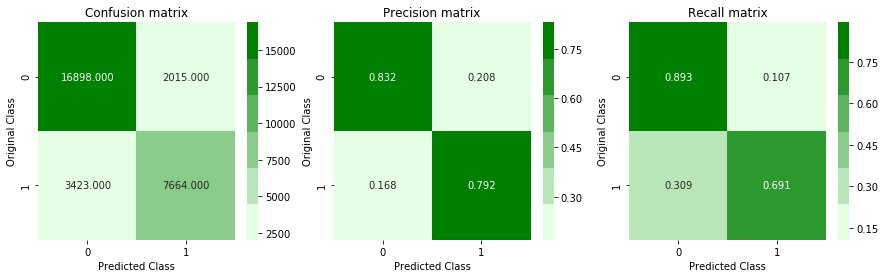

In [12]:
#getting all the performance matrices
y_pred = sig_xgb.predict(X_test)
y_pred_train =sig_xgb.predict(X_train)
acc_test = accuracy_score(y_test,y_pred)*100
print("test accuracy  is {0:.2f}%".format(acc_test))
accuracy_list.append(acc_test)
test_error = (100-acc_test)
print("test error : {0:.2f}%" .format(round(test_error,2)))
test_error_list.append(round(test_error,2))
train_error =( 1-accuracy_score(y_train,y_pred_train))*100
print("train error : {0:.2f}%" .format(round(train_error,2)))
train_error_list.append(round(train_error,2))
precision = precision_score(y_test,y_pred)*100
print("precision score : {0:.2f}%".format(round(precision,2)))
precision_list.append(precision)
recall= recall_score(y_test,y_pred)*100
print("Recall score : {0:.2f}%" .format(round(recall,2)))    
recall_list.append(recall)
f1score = f1_score(y_test,y_pred)*100
print("F1-score using  : {0:.2f}%".format(round(f1score,2)))
f1_score_list.append(f1score)

#ploting confusion matrix 
TN, FN, FP, TP = confusion_matrix_values(y_test, y_pred)
print('True positive = {}'.format(TP))
print('False positive = {}'.format(FP))
print('False negative = {}'.format(FN))
print('True negative = {}'.format(TN))
plot_confusion_matrix(y_test,y_pred)
              

## 7.3 Conclusions:

In [13]:
#reporting the results in a table
from prettytable import PrettyTable
order_list =[0]

for i in order_list:
    t= PrettyTable()
    t.field_names =["metric/Parameter" , "result"]
    t.add_row (["Model" ,"Classification"])
    t.add_row (["Classifier" ,"Xgboost"])
    t.add_row(["test_accuracy",round(accuracy_list[i],2)])
    t.add_row  (["test_error",round(test_error_list[i],2) ] )
    t.add_row  (["train_error",round(train_error_list[i],2) ] )
    t.add_row(["precision",round(precision_list[i],2)])
    t.add_row (["recall" ,round(recall_list[i],2)])
    t.add_row (["f1-score" , round(f1_score_list[i],2)])
    t.add_row (["train-logloss" , round(train_log_loss_list[i],5)])
    t.add_row (["test-logloss" , round(test_log_loss_list[i],5)])
    

    print(t)   

+------------------+----------------+
| metric/Parameter |     result     |
+------------------+----------------+
|      Model       | Classification |
|    Classifier    |    Xgboost     |
|  test_accuracy   |     81.87      |
|    test_error    |     18.13      |
|   train_error    |     17.74      |
|    precision     |     79.18      |
|      recall      |     69.13      |
|     f1-score     |     73.81      |
|  train-logloss   |    0.36011     |
|   test-logloss   |    0.37142     |
+------------------+----------------+


## 7.4  computing optimal hyperparameters  using RandomSearch 

In [8]:
#lists for saving results
train_log_loss_list = []
test_log_loss_list =[]
accuracy_list =[];
test_error_list =[];
train_error_list=[];
precision_list=[];
recall_list =[];
f1_score_list=[];

#parameters to tune to improve the model    
max_depth = [2,4,6,8,10]
n_estimators = [50,100,200,400,800,1000]
gamma= [i/10.0 for i in range(0,5)]
learning_rate = [0.001,0.01,0.1,0,10,100,100]
reg_alpha =[0, 0.001, 0.005, 0.01, 0.05]
min_child_weight = [2,4,6,8,10]

#dictionary of parameters for training using Randomsearchcv
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators,gamma=gamma,
                  learning_rate=learning_rate,reg_alpha=reg_alpha,min_child_weight=min_child_weight)

#initializing the Xgbboost
clf = XGBClassifier(objective= 'binary:logistic',seed=27)

#tuning parameter using randomsearchcv
xgb_rs= RandomizedSearchCV(clf,param_grid,cv=5, scoring="log_loss",n_jobs=-1,refit=True,verbose=1)
xgb_rs.fit(X_train, y_train)
print("best hyperparameters are:{}".format (xgb_rs.best_params_))
predict_y = xgb_rs.predict_proba(X_train)
train_log_loss =log_loss(y_train, predict_y, labels=xgb_rs.classes_, eps=1e-15)
train_log_loss_list.append(train_log_loss)
print( "The train log loss is:",train_log_loss)
predict_y = xgb_rs.predict_proba(X_test)
test_log_loss =log_loss(y_test, predict_y, labels=xgb_rs.classes_, eps=1e-15)
test_log_loss_list.append(test_log_loss)
print("The test log loss is:",test_log_loss)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed: 51.5min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 131.5min finished


best hyperparameters are:{'reg_alpha': 0.05, 'n_estimators': 400, 'min_child_weight': 2, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.1}
The train log loss is: 0.2619151658483818
The test log loss is: 0.3323557993047539


test accuracy  is 83.50%
test error : 16.50%
train error : 10.78%
precision score : 79.45%
Recall score : 74.65%
F1-score using  : 76.98%
True positive = 8276
False positive = 2811
False negative = 2140
True negative = 16773


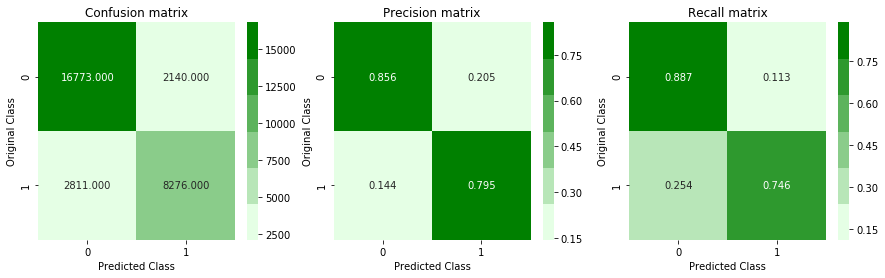

In [9]:
#getting the performance matrices
y_pred = xgb_rs.predict(X_test)
y_pred_train =xgb_rs.predict(X_train)
acc_test = accuracy_score(y_test,y_pred)*100
print("test accuracy  is {0:.2f}%".format(acc_test))
accuracy_list.append(acc_test)
test_error = (100-acc_test)
print("test error : {0:.2f}%" .format(round(test_error,2)))
test_error_list.append(round(test_error,2))
train_error =( 1-accuracy_score(y_train,y_pred_train))*100
print("train error : {0:.2f}%" .format(round(train_error,2)))
train_error_list.append(round(train_error,2))
precision = precision_score(y_test,y_pred)*100
print("precision score : {0:.2f}%".format(round(precision,2)))
precision_list.append(precision)
recall= recall_score(y_test,y_pred)*100
print("Recall score : {0:.2f}%" .format(round(recall,2)))    
recall_list.append(recall)
f1score = f1_score(y_test,y_pred)*100
print("F1-score using  : {0:.2f}%".format(round(f1score,2)))
f1_score_list.append(f1score)

#ploting confusion matrix
TN, FN, FP, TP = confusion_matrix_values(y_test, y_pred)
print('True positive = {}'.format(TP))
print('False positive = {}'.format(FP))
print('False negative = {}'.format(FN))
print('True negative = {}'.format(TN))
plot_confusion_matrix(y_test,y_pred)
              

## 7.5 Conclusions:

In [10]:
#reporting the results in a table
from prettytable import PrettyTable
order_list =[0]

for i in order_list:
    t= PrettyTable()
    t.field_names =["metric/Parameter" , "result"]
    t.add_row (["Model" ,"Classification"])
    t.add_row (["Classifier" ,"Xgboost"])
    t.add_row(["test_accuracy",round(accuracy_list[i],2)])
    t.add_row  (["test_error",round(test_error_list[i],2) ] )
    t.add_row  (["train_error",round(train_error_list[i],2) ] )
    t.add_row(["precision",round(precision_list[i],2)])
    t.add_row (["recall" ,round(recall_list[i],2)])
    t.add_row (["f1-score" , round(f1_score_list[i],2)])
    t.add_row (["train-logloss" , round(train_log_loss_list[i],5)])
    t.add_row (["test-logloss" , round(test_log_loss_list[i],5)])
    

    print(t)   

+------------------+----------------+
| metric/Parameter |     result     |
+------------------+----------------+
|      Model       | Classification |
|    Classifier    |    Xgboost     |
|  test_accuracy   |      83.5      |
|    test_error    |      16.5      |
|   train_error    |     10.78      |
|    precision     |     79.45      |
|      recall      |     74.65      |
|     f1-score     |     76.98      |
|  train-logloss   |    0.26192     |
|   test-logloss   |    0.33236     |
+------------------+----------------+


## 7.6 Using TF-IDF vectorization 

In [7]:
df = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
df1 =df.sample(100000) #taking only 100000 data-points
df1.reset_index(inplace=True)

In [8]:
df1.head(3)

,index,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,220428,220428,10321,10330,where do i find a simple to understand solutio...,how do i lose weight,1,0.999950,0.333328,0.999967,...,0.357140,1.0,0.0,9.0,9.5,100,45,43,86,0.590909
1,125066,125066,201834,201835,what are the advantages of xenotransplantation...,what are the advantages and disadvantages of x...,1,0.999967,0.999967,0.999975,...,0.699993,0.0,1.0,2.0,9.0,100,91,67,72,0.515152
2,172125,172125,133136,265847,can you justify appointment of mr urjit patel...,what do you think about the appointment of urj...,1,0.666656,0.499994,0.749981,...,0.466664,0.0,0.0,3.0,13.5,76,67,67,71,0.231884


## 7.6.1 Text-Preprocessing

In [9]:
#importing required libraries
import re

#pre-defined finctions to remove html tags ,punctuations, special characters

#function fro removing html tags
def remove_html (sentence):
    cleanhtml = re.compile('<.*?>')
    clean_text = re.sub(cleanhtml,' ',str(sentence))
    return clean_text

#function for removing punctuations and special characters
def remove_punc(sentence):
    cleanpunc = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleanpunc = re.sub(r'[.|,|)|(|\|/]',r' ',cleanpunc)
    cleanpunc = cleanpunc.strip()
    cleanpunc = cleanpunc.replace("\n" ,'')
    return cleanpunc
    
    
#function for keeping only alphabets
def keep_alpha(sentence):
    alpha_sentence = ""
    for word in sentence.split():
        alpha_word = re.sub('[^a-z A-Z]+', ' ', word)
        alpha_sentence += alpha_word
        alpha_sentence += " "
    alpha_sentence = alpha_sentence.strip()
    return alpha_sentence


In [10]:
#removing stopwords with some exceptions and do stemmming
#initializing stopwords with some exceptions words like not and very and stemming 
import nltk
#nltk.download("stopwords")

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
stop_words.update(['zero','one','two','three','four','five','six','seven','eight',
                   'nine','ten','may','also','however','yet'])
print(stop_words)

#function for removing stopwords

def remove_stopwords(sentence):
    no_stopword_review = ""
    for word in sentence.split():
        if word not in stop_words:
            no_stopword_review += word
            no_stopword_review += " "
    no_stopword_review = no_stopword_review.strip()
    return no_stopword_review


#stemming
sno = nltk.stem.SnowballStemmer('english')

#function to do stemming
def stem_remove(sentence):
    stem_sentence = ""
    for word in sentence.split():
        stem_word = sno.stem(word)
        stem_sentence += stem_word
        stem_sentence += " "
    stem_sentence = stem_sentence.strip()
    return stem_sentence


{'an', "mightn't", 'there', 'same', 'below', 'themselves', 'the', 'just', 'she', 'couldn', 'what', 'him', 'after', 'to', 'eight', "needn't", 'won', 'zero', 'between', 'for', "mustn't", 'shouldn', 'no', 'shan', "didn't", 'been', 't', 'don', "don't", 'not', 'about', 'her', "hasn't", 'nine', "should've", 'ours', 'o', "you'd", 'does', 'mustn', 'isn', 'during', 'itself', 'those', 'some', 'mightn', 'or', 'so', 'his', 'we', 's', 'have', 'own', 'aren', 'such', 'more', 'one', 'he', 'haven', 'any', 'when', 'your', 'how', 'two', "weren't", 'ma', 'why', 'are', 'into', 'had', 'but', 'myself', 'by', 'five', 'off', "shouldn't", 'most', 'nor', 'it', 'other', "that'll", 'can', 'did', 'also', 'i', 'himself', 'my', 'their', 'until', 'few', 'ourselves', 'too', 'of', "you'll", 'before', 'theirs', 'wouldn', 'weren', 'will', 'doing', 'above', 'once', 'who', "won't", 'you', 'three', 'our', 'me', "you've", 'which', 'with', 'now', 'll', "haven't", 'over', 'because', 'from', 'further', "aren't", 'may', 'where', 

In [11]:
#applying all pre-processing functions on the text to get cleaned text
df1['question1'] = df1['question1'].str.lower()
df1['question1'] = df1['question1'].apply(remove_html)
df1['question1'] = df1['question1'].apply(remove_punc)
df1['question1'] = df1['question1'].apply(keep_alpha)
df1['question1'] = df1['question1'].apply(remove_stopwords)
df1['question1'] = df1['question1'].apply(stem_remove)


df1['question2'] = df1['question2'].str.lower()
df1['question2'] = df1['question2'].apply(remove_html)
df1['question2'] = df1['question2'].apply(remove_punc)
df1['question2'] = df1['question2'].apply(keep_alpha)
df1['question2'] = df1['question2'].apply(remove_stopwords)
df1['question2'] = df1['question2'].apply(stem_remove)


In [12]:
df1.head(3)

,index,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,220428,220428,10321,10330,find simpl understand solut lose weight,lose weight,1,0.999950,0.333328,0.999967,...,0.357140,1.0,0.0,9.0,9.5,100,45,43,86,0.590909
1,125066,125066,201834,201835,advantag xenotransplant disadvantag,advantag disadvantag xenotransplant,1,0.999967,0.999967,0.999975,...,0.699993,0.0,1.0,2.0,9.0,100,91,67,72,0.515152
2,172125,172125,133136,265847,justifi appoint mr urjit patel next rbi govern,think appoint urjit patel governor rbi,1,0.666656,0.499994,0.749981,...,0.466664,0.0,0.0,3.0,13.5,76,67,67,71,0.231884


In [13]:
df1["questions"] = df1["question1"].map(str) +" "+ df1["question2"] #combing both the question for tf-idf vectorization
y_true1 = df1['is_duplicate']
y_true1 = list(map(int, y_true1.values))
df1 = df1.drop(["index","id","qid1","qid2","question1","question2","is_duplicate"],axis=1)

In [14]:
df1.head(3)

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,questions
0,0.999950,0.333328,0.999967,0.428565,0.999980,0.357140,1.0,0.0,9.0,9.5,100,45,43,86,0.590909,find simpl understand solut lose weight lose w...
1,0.999967,0.999967,0.999975,0.799984,0.874989,0.699993,0.0,1.0,2.0,9.0,100,91,67,72,0.515152,advantag xenotransplant disadvantag advantag d...
2,0.666656,0.499994,0.749981,0.428565,0.583328,0.466664,0.0,0.0,3.0,13.5,76,67,67,71,0.231884,justifi appoint mr urjit patel next rbi govern...


## Train-Test Split

In [15]:
#train0-test split
X_train1,X_test1, y_train1, y_test1 = train_test_split(df1, y_true1, stratify=y_true1, test_size=0.3)

In [16]:
train_text = X_train1["questions"]
test_text =X_test1["questions"]
train_feat = np.array(X_train1.drop(["questions"],axis=1)) #getting the extracted features seperatly
test_feat = np.array(X_test1.drop(["questions"],axis=1))

In [17]:
#vectorizing text using TF-IDF
vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,3), norm='l2',max_features =20000)
tfidf_train = vectorizer.fit_transform(train_text.values) #fitting on train data
print("the type of count vectorizer ",type(tfidf_train))
print("the shape of out text TFIDF vectorizer ",tfidf_train.get_shape())
print("the number of unique words including both unigrams and bigrams ", tfidf_train.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (70000, 20000)
the number of unique words including both unigrams and bigrams  20000


In [18]:
 #transforming test set
tfidf_test = vectorizer.transform(test_text.values)
print("the shape of out text TFIDF vectorizer ",tfidf_test.get_shape())

the shape of out text TFIDF vectorizer  (30000, 20000)


In [29]:
#combining tf-idf values and extracted features
X_train_final = np.concatenate((train_feat,tfidf_train.toarray()),axis=1) 

In [31]:
#combining tf-idf values and extracted features
X_test_final = np.concatenate((test_feat,tfidf_test.toarray()),axis=1)

## 7.6.2 Linear-SVM

For values of alpha =  1e-05 The log loss is: 0.544495550496473
For values of alpha =  0.0001 The log loss is: 0.547448272027989
For values of alpha =  0.001 The log loss is: 0.552102468584721
For values of alpha =  0.01 The log loss is: 0.5571382348205236
For values of alpha =  0.1 The log loss is: 0.5624003331570862
For values of alpha =  1 The log loss is: 0.6477415615236087
For values of alpha =  10 The log loss is: 0.5989476840246459


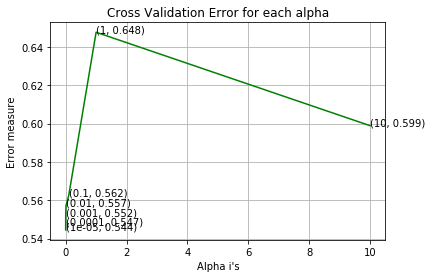

In [35]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.
log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42) #initializing linear-svm
    clf.fit(X_train_final, y_train1)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_final, y_train1)
    predict_y = sig_clf.predict_proba(X_test_final)
    log_error_array.append(log_loss(y_test1, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test1, predict_y, labels=clf.classes_, eps=1e-15))

#ploting log-loss with hange in alpha value    
fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

The train log loss is: 0.5486789724047465
The test log loss is: 0.544495550496473
test accuracy  is 70.21%
test error : 29.79%
train error : 30.15%
precision score : 62.31%
Recall score : 49.75%
F1-score using  : 55.33%
roc_auc_score using  : 0.66
True positive = 5534
False positive = 5589
False negative = 3348
True negative = 15529


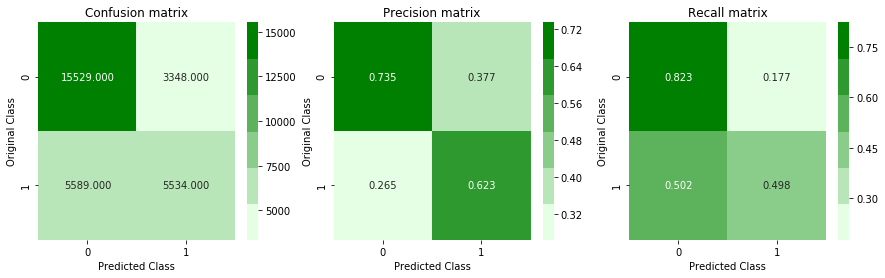

In [42]:
#list for saving the results
train_log_loss_list = []
test_log_loss_list =[]
accuracy_list =[];
test_error_list =[];
train_error_list=[];
precision_list=[];
recall_list =[];
f1_score_list=[];


#training the model using best alpha
best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train_final, y_train1)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_final, y_train1)
#getting the probabilities to get log-loss
predict_y = sig_clf.predict_proba(X_train_final)
train_log_loss =log_loss(y_train1, predict_y, labels=clf.classes_, eps=1e-15)
train_log_loss_list.append(train_log_loss)
print( "The train log loss is:",train_log_loss)
predict_y = sig_clf.predict_proba(X_test_final)
test_log_loss =log_loss(y_test1, predict_y, labels=clf.classes_, eps=1e-15)
test_log_loss_list.append(test_log_loss)
print("The test log loss is:",test_log_loss)

#getting the performance measures
y_pred = sig_clf.predict(X_test_final)
y_pred_train =sig_clf.predict(X_train_final)
acc_test = accuracy_score(y_test1,y_pred)*100
print("test accuracy  is {0:.2f}%".format(acc_test))
accuracy_list.append(acc_test)
test_error = (100-acc_test)
print("test error : {0:.2f}%" .format(round(test_error,2)))
test_error_list.append(round(test_error,2))
train_error =( 1-accuracy_score(y_train1,y_pred_train))*100
print("train error : {0:.2f}%" .format(round(train_error,2)))
train_error_list.append(round(train_error,2))
precision = precision_score(y_test1,y_pred)*100
print("precision score : {0:.2f}%".format(round(precision,2)))
precision_list.append(precision)
recall= recall_score(y_test1,y_pred)*100
print("Recall score : {0:.2f}%" .format(round(recall,2)))    
recall_list.append(recall)
f1score = f1_score(y_test1,y_pred)*100
print("F1-score using  : {0:.2f}%".format(round(f1score,2)))
f1_score_list.append(f1score)

#plotting confusion matrix
TN, FN, FP, TP = confusion_matrix_values(y_test1, y_pred)
print('True positive = {}'.format(TP))
print('False positive = {}'.format(FP))
print('False negative = {}'.format(FN))
print('True negative = {}'.format(TN))
plot_confusion_matrix(y_test1,y_pred)
              

In [44]:
#reporting the results in a table
from prettytable import PrettyTable
order_list =[0]

for i in order_list:
    t= PrettyTable()
    t.field_names =["metric/Parameter" , "result"]
    t.add_row (["Model" ,"Classification"])
    t.add_row (["Classifier" ,"Linear-SVM"])
    t.add_row(["test_accuracy",round(accuracy_list[i],2)])
    t.add_row  (["test_error",round(test_error_list[i],2) ] )
    t.add_row  (["train_error",round(train_error_list[i],2) ] )
    t.add_row(["precision",round(precision_list[i],2)])
    t.add_row (["recall" ,round(recall_list[i],2)])
    t.add_row (["f1-score" , round(f1_score_list[i],2)])
    t.add_row (["train-logloss" , round(train_log_loss_list[i],5)])
    t.add_row (["test-logloss" , round(test_log_loss_list[i],5)])
    

    print(t)   

+------------------+----------------+
| metric/Parameter |     result     |
+------------------+----------------+
|      Model       | Classification |
|    Classifier    |   Linear-SVM   |
|  test_accuracy   |     70.21      |
|    test_error    |     29.79      |
|   train_error    |     30.15      |
|    precision     |     62.31      |
|      recall      |     49.75      |
|     f1-score     |     55.33      |
|  train-logloss   |    0.54868     |
|   test-logloss   |     0.5445     |
+------------------+----------------+


## 7.6.3 Logistic-Regression

For values of alpha =  1e-05 The log loss is: 0.5451611836358193
For values of alpha =  0.0001 The log loss is: 0.5486710574395607
For values of alpha =  0.001 The log loss is: 0.5530521106348882
For values of alpha =  0.01 The log loss is: 0.552990190360737
For values of alpha =  0.1 The log loss is: 0.5671392001508229
For values of alpha =  1 The log loss is: 0.6216983463901802
For values of alpha =  10 The log loss is: 0.6593624539255812


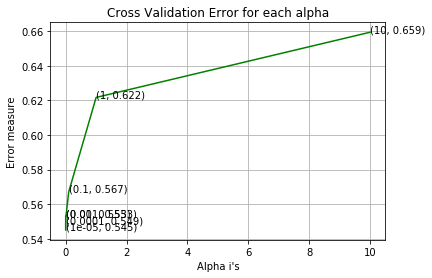

In [45]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

log_error_array=[]

for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='log', random_state=42)
    clf.fit(X_train_final, y_train1)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_final, y_train1)
    predict_y = sig_clf.predict_proba(X_test_final)
    log_error_array.append(log_loss(y_test1, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test1, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()
    

The train log loss is: 0.5493018363663191
The test log loss is: 0.5451611836358193
test accuracy  is 70.18%
test error : 29.82%
train error : 30.02%
precision score : 62.41%
Recall score : 49.22%
F1-score using  : 55.04%
True positive = 5475
False positive = 5648
False negative = 3297
True negative = 15580


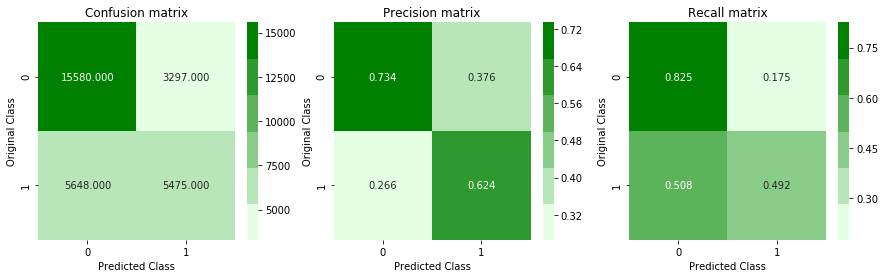

In [46]:
#lists for saving the results
train_log_loss_list = []
test_log_loss_list =[]
accuracy_list =[];
test_error_list =[];
train_error_list=[];
precision_list=[];
recall_list =[];
f1_score_list=[];

#training the model using best-alpha value
best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='log', random_state=42)
clf.fit(X_train_final, y_train1)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_final, y_train1)
predict_y = sig_clf.predict_proba(X_train_final)
train_log_loss =log_loss(y_train1, predict_y, labels=clf.classes_, eps=1e-15)
train_log_loss_list.append(train_log_loss)
print( "The train log loss is:",train_log_loss)
predict_y = sig_clf.predict_proba(X_test_final)
test_log_loss =log_loss(y_test1, predict_y, labels=clf.classes_, eps=1e-15)
test_log_loss_list.append(test_log_loss)
print("The test log loss is:",test_log_loss)

#getting all the performance matrices
y_pred = sig_clf.predict(X_test_final)
y_pred_train =sig_clf.predict(X_train_final)
acc_test = accuracy_score(y_test1,y_pred)*100
print("test accuracy  is {0:.2f}%".format(acc_test))
accuracy_list.append(acc_test)
test_error = (100-acc_test)
print("test error : {0:.2f}%" .format(round(test_error,2)))
test_error_list.append(round(test_error,2))
train_error =( 1-accuracy_score(y_train1,y_pred_train))*100
print("train error : {0:.2f}%" .format(round(train_error,2)))
train_error_list.append(round(train_error,2))
precision = precision_score(y_test1,y_pred)*100
print("precision score : {0:.2f}%".format(round(precision,2)))
precision_list.append(precision)
recall= recall_score(y_test1,y_pred)*100
print("Recall score : {0:.2f}%" .format(round(recall,2)))    
recall_list.append(recall)
f1score = f1_score(y_test1,y_pred)*100
print("F1-score using  : {0:.2f}%".format(round(f1score,2)))
f1_score_list.append(f1score)

#ploting confusion matrix
TN, FN, FP, TP = confusion_matrix_values(y_test1, y_pred)
print('True positive = {}'.format(TP))
print('False positive = {}'.format(FP))
print('False negative = {}'.format(FN))
print('True negative = {}'.format(TN))
plot_confusion_matrix(y_test1,y_pred)
                  

In [47]:
#reporting the results in a table
from prettytable import PrettyTable
order_list =[0]

for i in order_list:
    t= PrettyTable()
    t.field_names =["metric/Parameter" , "result"]
    t.add_row (["Model" ,"Classification"])
    t.add_row (["Classifier" ,"Logistic-Regression"])
    t.add_row(["test_accuracy",round(accuracy_list[i],2)])
    t.add_row  (["test_error",round(test_error_list[i],2) ] )
    t.add_row  (["train_error",round(train_error_list[i],2) ] )
    t.add_row(["precision",round(precision_list[i],2)])
    t.add_row (["recall" ,round(recall_list[i],2)])
    t.add_row (["f1-score" , round(f1_score_list[i],2)])
    t.add_row (["train-logloss" , round(train_log_loss_list[i],5)])
    t.add_row (["test-logloss" , round(test_log_loss_list[i],5)])
    

    print(t)   

+------------------+---------------------+
| metric/Parameter |        result       |
+------------------+---------------------+
|      Model       |    Classification   |
|    Classifier    | Logistic-Regression |
|  test_accuracy   |        70.18        |
|    test_error    |        29.82        |
|   train_error    |        30.02        |
|    precision     |        62.41        |
|      recall      |        49.22        |
|     f1-score     |        55.04        |
|  train-logloss   |        0.5493       |
|   test-logloss   |       0.54516       |
+------------------+---------------------+
